Following [a comment by Ramiro Gomez](http://geeksta.net/visualizations/age-musicians-die/#comment-2530578283), I will try to do some interactive Bokeh charts on smooth data about dying musicians in this blog post.

To see the original plots by Ramiro Gomez, click here: <http://geeksta.net/visualizations/age-musicians-die/>.

# Getting the data into pandas 

First, let's download the data, which is given as a google spreadsheet. Fortunately, [someone has already done this sort of thing before](http://stackoverflow.com/questions/24063629/loading-a-generic-google-spreadsheet-in-pandas):

In [1]:
url = "https://docs.google.com/spreadsheets/d/1QzUjVoDHK0zqLVLq-Z5gNMQRYLaR8B_7H_Em4rYOOJE/export?format=csv&gid=0"

In [2]:
import requests
r = requests.get(url)
data = r.content.decode('utf-8')

In [3]:
import pandas as pd

In [4]:
from io import StringIO 
df = pd.read_csv(StringIO(data),index_col=0,parse_dates=[0], thousands=',')

In [5]:
df.head()

,__all__,male,female,myocardial_infarction,cancer,lung_cancer,suicide,pneumonia,stroke,cardiovascular_disease,...,piano,guitar,saxophone,jazz_piano,violin,drum_kit,bass_guitar,double_bass,trumpet,clarinet
age,,,,,,,,,,,,,,,,,,,,,
14,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,2,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17,4,1,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
18,6,3,2,0,0,0,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0
19,14,6,5,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can do a quick plot using pandas of this data, for instance the all category:

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')

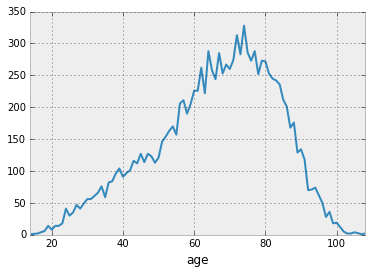

In [7]:
df.__all__.plot()

This looks exactly like the data on Ramiro's page. So let's move on.

# Smoothing the data using a convolution 

We want to replace the data in each column by a smoothed version of the data. Let's do that on an example, for which we'll choose the above data.

In [8]:
vals = df.__all__.values

In [9]:
vals

array([  1,   2,   4,   6,  14,   8,  14,  14,  18,  41,  30,  35,  47,
        41,  49,  56,  56,  61,  66,  76,  59,  82,  84,  96, 104,  91,
        97, 101, 116, 112, 127, 114, 127, 123, 113, 121, 146, 154, 163,
       170, 157, 206, 211, 190, 205, 226, 226, 262, 222, 288, 258, 244,
       285, 253, 267, 260, 274, 313, 283, 328, 286, 273, 288, 252, 273,
       272, 253, 245, 242, 236, 212, 201, 168, 176, 129, 134, 118,  70,
        71,  74,  62,  50,  28,  36,  18,  19,  12,   5,   2,   2,   4,
         1,   2], dtype=int64)

We will smooth our data using a convolution with a Gaussian kernel. The idea is that this will average the values in our series over a certain age range, while still retaining the overall shape. The code is inspired by [this question](http://stackoverflow.com/questions/22291567/smooth-data-and-find-maximum).

In [10]:
import scipy.signal

def smooth_data(data, bw):
    """Smooth the data using scipy.signal.convolve and a Gaussian window."""
    # make a gaussian window
    window = scipy.signal.gaussian(data.size, bw)
    # convolve the arrays
    smoothed = scipy.signal.convolve(data, window/window.sum(), mode='same')
    return smoothed

Let's use the real age values on the x-axis:

In [11]:
ages = df.index.values

Let's now compute the smooth data and plot it :

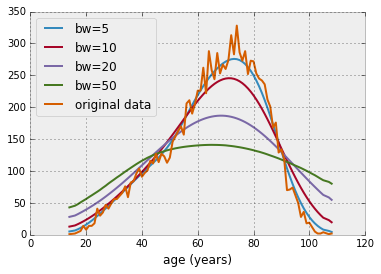

In [12]:
for bw in [5, 10, 20, 50]:
    plt.plot(ages, smooth_data(vals, bw), label='bw={}'.format(bw))
plt.plot(ages, vals, label='original data')
plt.xlabel('age (years)')
plt.legend(loc='upper left')

By looking at the plot above, choosing a value of 5 for the kernel standard deviation seems reasonable to fit the data. We can now apply this to every column of our initial dataframe.

In [13]:
df_smoothed = df.copy()
for col in df_smoothed.columns:
    df_smoothed[col] = smooth_data(df_smoothed[col].values, 5)

Let's now go on and do some interactive plotting with this.

# Doing interactive plotting using bokeh 

Now that we have a smoothed version of our data, we can use bokeh to plot this data. We'll use the high level API to get started and integrate some lower level elements as we go along. First, let's plot male and females, as well as overall total.

In [14]:
import bokeh.plotting as bp

In [15]:
from bokeh.models import HoverTool

In [16]:
import bokeh.charts as bc

In [17]:
bp.output_notebook()

Loading BokehJS ...

In [18]:
hover = HoverTool(
        tooltips=[
            ("age", "@x_values"),
            ("dead", "@y_values"),
            ("category", "@series")
        ]
    )

p = bc.Line(df_smoothed, x='index', y=['__all__', 'male', 'female'], 
            xlabel='age (years)', ylabel='count',
           tools=[hover, 'pan', 'box_zoom', 'ywheel_zoom'],
             legend='top_left',
           width=1000)

bp.show(p)

To do something more interactive, I added a hover tooltip that explains the meaning of the lines.

Now, let's plot the different musical styles:

In [19]:
hover = HoverTool(
        tooltips=[
            ("age", "@x_values"),
            ("dead", "@y_values"),
            ("category", "@series")
        ]
    )

p = bc.Line(df_smoothed, x='index', y=['jazz', 'opera', 'rock_music', 'european_classical_music',
                                     'country', 'blues', 'pop_music', 'rhythm_and_blues', 'film_score',
                                 'folk_music'], 
            xlabel='age (years)', ylabel='count',
           tools=[hover, 'pan', 'box_zoom', 'ywheel_zoom'],
            legend='top_left',
           width=1000)

bp.show(p)

Playing jazz seems to be a safer occupation than playing rock music...

Now, let's plot according to instruments:

In [20]:
hover = HoverTool(
        tooltips=[
            ("age", "@x_values"),
            ("dead", "@y_values"),
            ("category", "@series")
        ]
    )

p = bc.Line(df_smoothed, x='index', y=['piano', 'guitar', 'saxophone', 'jazz_piano', 'violin',
                                 'drum_kit', 'bass_guitar', 'double_bass', 'trumpet', 'clarinet'], 
            xlabel='age (years)', ylabel='count',
           tools=[hover, 'pan', 'box_zoom', 'ywheel_zoom'],
            legend='top_left',
           width=1000)

bp.show(p)

Based on this curves, guitar looks like a dangerous instrument, while piano does not!

Finally, let's do a plot according to the causes of death:

In [21]:
hover = HoverTool(
        tooltips=[
            ("age", "@x_values"),
            ("dead", "@y_values"),
            ("category", "@series")
        ]
    )

p = bc.Line(df_smoothed, x='index', y=['myocardial_infarction',  'cancer',  'lung_cancer',  'suicide',
                                 'pneumonia', 'stroke', 'cardiovascular_disease', 'murder', 'car_accident', 'drug_overdose'], 
            xlabel='age (years)', ylabel='count',
           tools=[hover, 'pan', 'box_zoom', 'ywheel_zoom'],
            legend='top_left',
           width=1000)

bp.show(p)

Clearly, if musicians commit suicide, they do it when they're young (same thing for drug overdose)! Also, heart attacks happen around 50, as do cancers. 

# Conclusions 

What we did in this notebook was: get the data, smooth it, and display it for interactive use in the browser. We've used pandas, scipy and bokeh to get there. This demonstrates how easy to use the high level API for bokeh is for everyday plotting.